In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Фиксируем random_state для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Загрузка и подготовка данных
print("=== ЗАГРУЗКА ДАННЫХ ===")
df = pd.read_csv('Reviews.csv')

# Обработка пропусков
df_clean = df.dropna(subset=['Text', 'Summary'])

# Создание целевой переменной
df_clean = df_clean[df_clean['Score'] != 3]  # Удаляем нейтральные отзывы
df_clean['sentiment'] = df_clean['Score'].apply(lambda x: 1 if x > 3 else 0)

print(f"Размер датасета после очистки: {df_clean.shape}")
print(f"Доля позитивных отзывов: {df_clean['sentiment'].mean():.2%}")



=== ЗАГРУЗКА ДАННЫХ ===
Размер датасета после очистки: (525789, 11)
Доля позитивных отзывов: 84.40%


In [10]:
# ## Разбиение на тренировочную и тестовую выборки
# **Обоснование:** Для корректной оценки качества модели необходимо разделить данные на тренировочную и тестовую выборки. f
print("=== РАЗБИЕНИЕ НА ВЫБОРКИ ===")

# Выделяем фичи и целевую переменную
X = df_clean['Text']  # Текст отзыва
y = df_clean['sentiment']  # Сентимент

# Стратифицированное разбиение 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y  # Сохраняем распределение классов
)

print(f"Размер тренировочной выборки: {X_train.shape[0]:,}")
print(f"Размер тестовой выборки: {X_test.shape[0]:,}")
print(f"Доля позитивных в тренировочной: {y_train.mean():.2%}")
print(f"Доля позитивных в тестовой: {y_test.mean():.2%}")

=== РАЗБИЕНИЕ НА ВЫБОРКИ ===
Размер тренировочной выборки: 420,631
Размер тестовой выборки: 105,158
Доля позитивных в тренировочной: 84.40%
Доля позитивных в тестовой: 84.40%


In [4]:
# ## Измерение качества константного предсказания
# **Обоснование:** Константное предсказание (most frequent class) служит минимальным бейзлайном.
# Если модель не превосходит это значение, она бесполезна.
print("=== КОНСТАНТНОЕ ПРЕДСКАЗАНИЕ ===")

# Наиболее частый класс в тренировочной выборке
most_frequent_class = y_train.mode()[0]
print(f"Наиболее частый класс: {most_frequent_class} ({'позитивный' if most_frequent_class == 1 else 'негативный'})")

# Константное предсказание
y_pred_constant = np.full_like(y_test, most_frequent_class)

# Оценка качества
constant_f1 = f1_score(y_test, y_pred_constant)
print(f"F1-score константного предсказания: {constant_f1:.4f}")

=== КОНСТАНТНОЕ ПРЕДСКАЗАНИЕ ===
Наиболее частый класс: 1 (позитивный)
F1-score константного предсказания: 0.9154


In [5]:
# ## Предобработка текстовых данных
# **Обоснование:** Для работы с текстовыми данными в ML-моделях необходимо преобразовать текст в числовые признаки.
# Используем TF-IDF векторизацию, которая учитывает важность слов в документе и во всей коллекции.
print("=== ПРЕДОБРАБОТКА ТЕКСТА ===")

# Создаем TF-IDF векторизатор
# Ограничиваем количество фич для скорости и избежания переобучения
vectorizer = TfidfVectorizer(
    max_features=5000,        # Ограничиваем количество слов
    stop_words='english',     # Удаляем стоп-слова
    ngram_range=(1, 2),       # Учитываем униграммы и биграммы
    min_df=5,                 # Игнорируем редкие слова
    max_df=0.7                # Игнорируем слишком частые слова
)

# Обучаем векторизатор на тренировочных данных и преобразуем все данные
print("Векторизация текста...")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Размерность тренировочной матрицы: {X_train_tfidf.shape}")
print(f"Размерность тестовой матрицы: {X_test_tfidf.shape}")


=== ПРЕДОБРАБОТКА ТЕКСТА ===
Векторизация текста...
Размерность тренировочной матрицы: (420631, 5000)
Размерность тестовой матрицы: (105158, 5000)


In [11]:
# ## Бейзлайновая модель: Логистическая регрессия
# **Обоснование выбора модели:**
# - Линейные модели хорошо работают с разреженными текстовыми данными
# - Быстрое обучение и предсказание
# - Хорошая интерпретируемость
# - Часто используются как бейзлайн в задачах текстовой классификации
print("=== БЕЙЗЛАЙН: ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ ===")

# Создаем и обучаем модель
logreg_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,  # Увеличиваем количество итераций для сходимости
    C=1.0           # Стандартный параметр регуляризации
)

print("Обучение логистической регрессии...")
logreg_model.fit(X_train_tfidf, y_train)

# Предсказания на тестовой выборке
y_pred_logreg = logreg_model.predict(X_test_tfidf)

# Оценка качества
logreg_f1 = f1_score(y_test, y_pred_logreg)
print(f"F1-score логистической регрессии: {logreg_f1:.4f}")


=== БЕЙЗЛАЙН: ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ ===
Обучение логистической регрессии...
F1-score логистической регрессии: 0.9597


In [12]:
# ## Дополнительная бейзлайн модель: Дерево решений
# **Обоснование:** Деревья решений представляют другой класс моделей (нелинейные), что позволяет сравнить разные подходы.
print("=== ДОПОЛНИТЕЛЬНАЯ МОДЕЛЬ: ДЕРЕВО РЕШЕНИЙ ===")

# Создаем и обучаем дерево решений
tree_model = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    max_depth=10,  # Ограничиваем глубину для избежания переобучения
    min_samples_split=20  # Минимальное количество samples для разделения
)

print("Обучение дерева решений...")
tree_model.fit(X_train_tfidf, y_train)

# Предсказания на тестовой выборке
y_pred_tree = tree_model.predict(X_test_tfidf)

# Оценка качества
tree_f1 = f1_score(y_test, y_pred_tree)
print(f"F1-score дерева решений: {tree_f1:.4f}")

=== ДОПОЛНИТЕЛЬНАЯ МОДЕЛЬ: ДЕРЕВО РЕШЕНИЙ ===
Обучение дерева решений...
F1-score дерева решений: 0.9262


=== СРАВНЕНИЕ КАЧЕСТВА МОДЕЛЕЙ ===
                     Модель  F1-Score
0  Константное предсказание  0.915416
1   Логистическая регрессия  0.959727
2            Дерево решений  0.926210


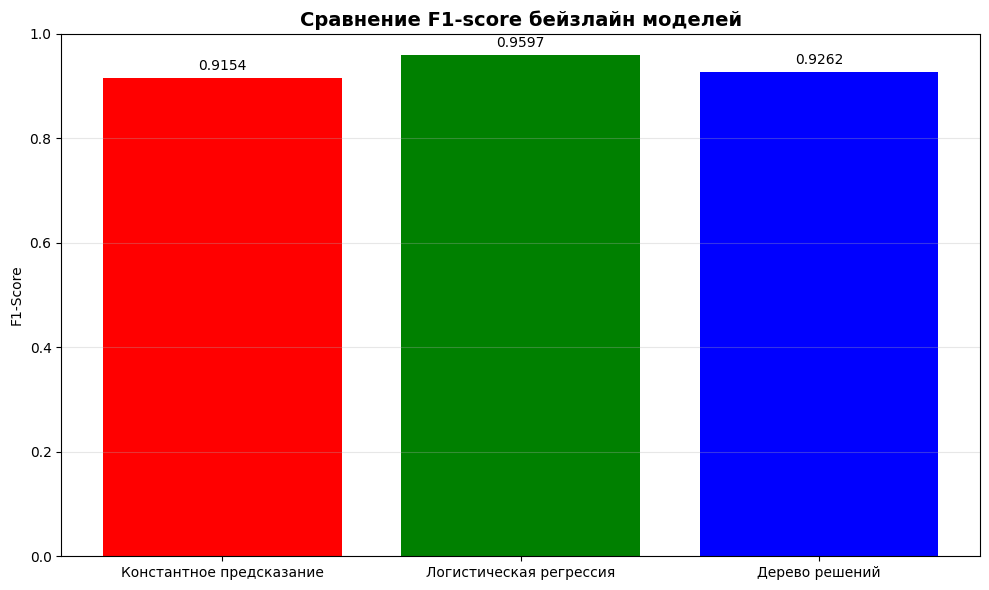

In [15]:
# ## Сравнение качества моделей
print("=== СРАВНЕНИЕ КАЧЕСТВА МОДЕЛЕЙ ===")

models_comparison = pd.DataFrame({
    'Модель': ['Константное предсказание', 'Логистическая регрессия', 'Дерево решений'],
    'F1-Score': [constant_f1, logreg_f1, tree_f1]
})

print(models_comparison)

# %%
# Визуализация сравнения
plt.figure(figsize=(10, 6))
bars = plt.bar(models_comparison['Модель'], models_comparison['F1-Score'], color=['red', 'green', 'blue'])
plt.title('Сравнение F1-score бейзлайн моделей', fontsize=14, fontweight='bold')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# Добавляем подписи значений
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# %%

=== ДЕТАЛЬНЫЙ АНАЛИЗ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ ===
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.68      0.76     16402
           1       0.94      0.98      0.96     88756

    accuracy                           0.93    105158
   macro avg       0.89      0.83      0.86    105158
weighted avg       0.93      0.93      0.93    105158



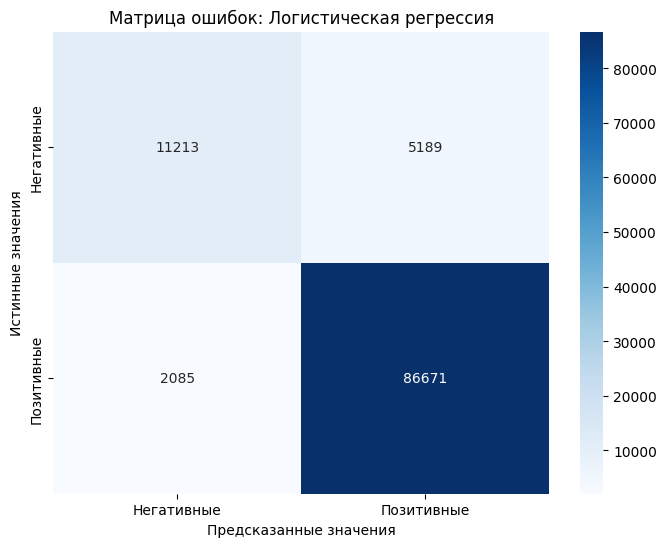

Топ-20 слов для позитивных отзывов:
               feature  importance
2029             great   11.406767
1224         delicious   11.283673
370               best   10.292752
3277           perfect   10.192737
1558         excellent    8.895432
2770             loves    8.331135
182            amazing    8.235010
282            awesome    8.200722
4917  won disappointed    7.499758
4920         wonderful    7.380843
2249            hooked    7.158579
4993             yummy    7.099017
3348           pleased    7.096388
1622         fantastic    7.071618
2225  highly recommend    6.872847
2745              love    6.840185
4050            smooth    6.730344
2449        just right    6.678300
1940              good    6.252371
3672        refreshing    6.133552

Топ-20 слов для негативных отзывов:
             feature  importance
4945           worst  -12.106462
1322   disappointing  -10.294390
4471        terrible   -9.103803
1321    disappointed   -8.837582
1323  disappointment   -8.6

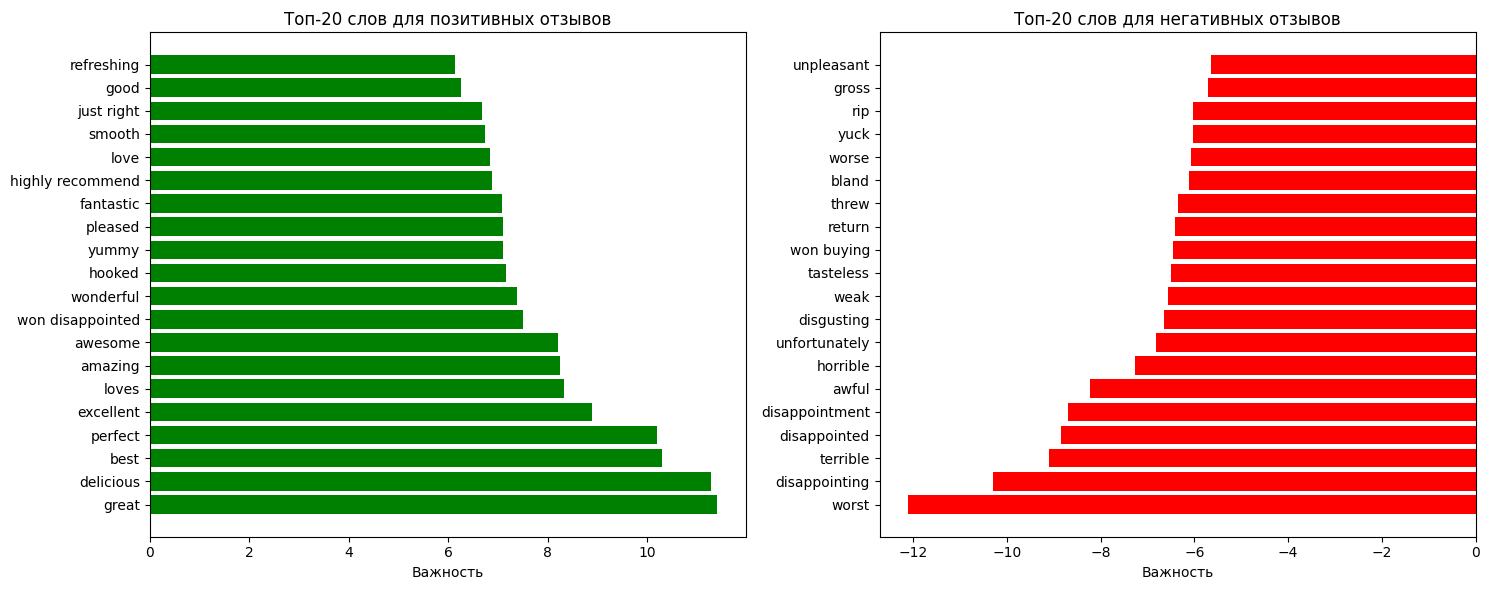

In [14]:
# ## Детальная оценка лучшей модели
print("=== ДЕТАЛЬНЫЙ АНАЛИЗ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ ===")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Негативные', 'Позитивные'],
            yticklabels=['Негативные', 'Позитивные'])
plt.title('Матрица ошибок: Логистическая регрессия')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()

# ## Анализ важности признаков
# Получаем важность признаков для логистической регрессии
feature_names = vectorizer.get_feature_names_out()
coefficients = logreg_model.coef_[0]

# Создаем DataFrame с важностью признаков
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': coefficients
})

# Топ-20 самых важных признаков для позитивного класса
top_positive = feature_importance.nlargest(20, 'importance')
top_negative = feature_importance.nsmallest(20, 'importance')

print("Топ-20 слов для позитивных отзывов:")
print(top_positive)

print("\nТоп-20 слов для негативных отзывов:")
print(top_negative)

# Визуализация важных признаков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Позитивные слова
ax1.barh(top_positive['feature'], top_positive['importance'], color='green')
ax1.set_title('Топ-20 слов для позитивных отзывов')
ax1.set_xlabel('Важность')

# Негативные слова
ax2.barh(top_negative['feature'], top_negative['importance'], color='red')
ax2.set_title('Топ-20 слов для негативных отзывов')
ax2.set_xlabel('Важность')

plt.tight_layout()
plt.show()